In [1]:
# Example python program to read data from a PostgreSQL table

# and load into a pandas DataFrame

import psycopg2

import pandas as pd

import re

from sqlalchemy import create_engine

In [8]:
dbUser = "postgres"
dbPassword = "postgres"
dbHostname = "localhost"
dbPort = 5432
dbName = "tinkoff"

connectionString = "postgresql://%s:%s@%s:%d/%s?sslmode=disable" % (dbUser, dbPassword, dbHostname, dbPort, dbName)
# Create an engine instance
alchemyEngine = create_engine(connectionString, pool_recycle=3600);

In [47]:
# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect();

# Read data from PostgreSQL database table and load into a DataFrame instance
df = pd.read_sql("""
SELECT name, instrument.id, figi, ts, open_price, close_price, high_price, low_price, volume
FROM candle
LEFT JOIN instrument
 ON candle.instrument_id=instrument.id""", dbConnection);

pd.set_option('display.expand_frame_repr', False);

# Close the database connectio
dbConnection.close();

# Drop duplicates
df = df.drop_duplicates()

# Print the DataFrame
df.shape

(799607, 9)

## Generate parquet

In [52]:
df.to_parquet("data.parquet", compression='gzip')

## Load parquet

In [157]:
df = pd.read_parquet("data.parquet")

In [158]:
df.head()

,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:30:00+00:00,114.02,114.02,114.02,114.02,10.0
2,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:45:00+00:00,114.33,114.23,114.41,114.16,138376.0
3,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:30:00+00:00,114.33,114.32,114.37,114.25,56589.0
4,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:15:00+00:00,114.18,114.33,114.34,114.16,68477.0


## Limit instruments count

In [169]:
df = df[df["id"] < 100]

In [184]:
instruments_count = df["id"].unique().size

## Preprocess data

In [240]:
metric_names = ['open_price','close_price','high_price','low_price','volume']

df_data_set = pd.DataFrame()

for metric_name in metric_names:
    # Pivot table and create data set part with single metric
    df_buf = df.pivot(index='ts', columns='id')[metric_name]
    
    # Rename column
    df_buf.columns = ['%s_%d' % (metric_name, x) for x in df_buf.columns]
    
    # Concat dataset
    df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)

# Add timestamp features
df_data_set['year'] = df_data_set.index.year
df_data_set['month'] = df_data_set.index.month
df_data_set['day'] = df_data_set.index.day
df_data_set['weekday'] = df_data_set.index.weekday
df_data_set['hour'] = df_data_set.index.hour
df_data_set['minute'] = df_data_set.index.minute

# Add target column
target_name = 'open_price'
# Pivot table and create data set part with single metric
df_buf = df.pivot(index='ts', columns='id')[target_name]
# Add target metric
df_buf = df_buf.shift(-1)
# Rename column
df_buf.columns = ['target_%d' % x for x in df_buf.columns]
# Concat dataset
df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)

# Fill NAN
df_data_set = df_data_set.fillna(method='ffill')

# Remove nan
df_data_set = df_data_set.dropna()

# Create non time columns list
data_columns_list = [x for x in df_data_set.columns if re.match('.*_\d+', x) is not None]

# Calc percentage
# df_data_set[data_columns_list] /= df_data_set[data_columns_list].iloc[0]
# Calc derivative for each column
# df_data_set[data_columns_list] = df_data_set[data_columns_list].diff()
# # Fill first row with zeros
# df_data_set = df_data_set.fillna(0)

# Normalize data
column_normalizer = {'year':3000, 'month':12, 'day':31, 'weekday':7, 'hour':24, 'minute':60}
for column_name, normalizer_val in column_normalizer.items():
    df_data_set[column_name] /= normalizer_val

# # Calc percentage
# # df_data_set /= df_data_set.iloc[0]
# # Calc derivative for each column
# df_data_set = df_data_set.diff()
# # Fill first row with zeros
# df_data_set = df_data_set.fillna(0)

print(df_data_set.shape)
df_data_set.describe()

(854, 504)


,open_price_1,open_price_2,open_price_3,open_price_4,open_price_5,open_price_6,open_price_7,open_price_8,open_price_10,open_price_11,...,target_89,target_90,target_91,target_92,target_93,target_94,target_95,target_96,target_97,target_98
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,...,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,109.171159,192.975351,29.626792,47.668744,33.008021,55.166686,67.401089,48.304859,1703.191475,251.371979,...,105.588091,102.226393,300.251604,41.089906,328.373009,8.540984,59.558349,54.386932,25.541300,199.534684
std,1.452197,2.119614,0.398270,0.620292,0.719060,0.443919,0.853080,0.644398,21.516494,3.665650,...,0.785222,1.002760,4.766058,1.927380,7.819771,0.109944,0.750689,0.586098,0.530876,1.494830
min,106.090000,188.340000,28.800000,45.965000,31.740000,53.990000,65.460000,47.190000,1649.500000,242.180000,...,103.730000,99.650000,292.310000,37.420000,313.340000,8.240000,57.850000,52.880000,24.560000,196.140000
25%,107.892500,191.120000,29.260000,47.215625,32.450000,54.800000,66.660000,47.830000,1688.755000,249.697500,...,104.910000,101.870000,295.895000,39.622500,321.870000,8.490000,59.050000,53.840000,24.980000,198.550000
50%,108.685000,192.505000,29.500000,47.807500,32.750000,55.190000,67.430000,48.090000,1702.060000,252.770000,...,105.550000,102.450000,299.160000,41.195000,329.655000,8.550000,59.580000,54.550000,25.720000,199.500000
75%,110.640000,195.100000,30.000000,48.131250,33.727500,55.580000,68.250000,48.860000,1716.497500,254.237500,...,106.357500,103.030000,304.477500,41.900000,335.110000,8.610000,60.030000,54.810000,26.040000,200.210000
max,111.880000,196.640000,30.400000,48.612500,34.640000,56.010000,69.130000,49.730000,1761.730000,256.510000,...,107.270000,103.960000,308.870000,47.630000,339.770000,8.750000,62.830000,55.640000,26.420000,205.090000


<AxesSubplot:xlabel='ts'>

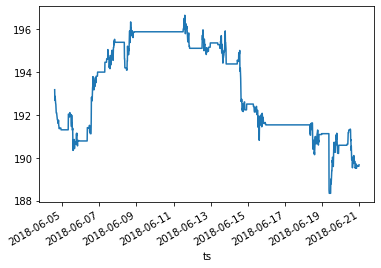

In [241]:
df_data_set.iloc[:,1].plot()

# Neural network

In [242]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from tensorflow.python.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

import numpy as np

import matplotlib.pyplot as plt

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2580015578074577765
]


In [243]:
y_size = instruments_count
X_size = df_data_set.shape[1] - y_size


# Cut features and targets
X = df_data_set.iloc[:,:X_size]
y = df_data_set.iloc[:,X_size:X_size+y_size]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# scale inputs with MinMaxScaler()
input_scaler =  MinMaxScaler()
# fit scaler
input_scaler.fit(X_train)
# transform training dataset
X_train = input_scaler.transform(X_train)
# transform test dataset
X_test = input_scaler.transform(X_test)

# Transform output with MinMaxScaler()
output_scaler = MinMaxScaler()
# fit scaler on training dataset
output_scaler.fit(y_train)
# transform training dataset
y_train = output_scaler.transform(y_train)
# transform test dataset
y_test = output_scaler.transform(y_test)

# Reshape and create loopback
look_back = 50

def reshape_with_look_back(look_back, dataset):
    output = np.ndarray(((dataset.shape[0] - look_back), look_back + 1, dataset.shape[1]))

    for i in range(look_back, dataset.shape[0]):
        output[i-look_back] = dataset[i-look_back:i+1]

    return output

# Create look back for input
X_train = reshape_with_look_back(look_back, X_train)
X_test = reshape_with_look_back(look_back, X_test)

# Adopt look back for output
y_train = y_train[look_back:]
y_test = y_test[look_back:]

# TODO Add forward days
# foward_days = 50

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(633, 51, 421)
(633, 83)
(121, 51, 421)
(121, 83)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_133 (LSTM)              (None, 51, 100)           208800    
_________________________________________________________________
dropout_32 (Dropout)         (None, 51, 100)           0         
_________________________________________________________________
lstm_134 (LSTM)              (None, 51, 100)           80400     
_________________________________________________________________
dropout_33 (Dropout)         (None, 51, 100)           0         
_________________________________________________________________
lstm_135 (LSTM)              (None, 51, 100)           80400     
_________________________________________________________________
dropout_34 (Dropout)         (None, 51, 100)           0         
_________________________________________________________________
lstm_136 (LSTM)              (None, 100)               80400     
__________

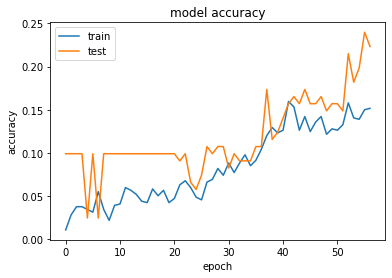

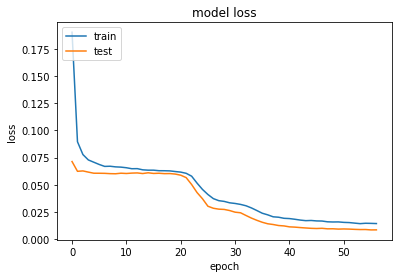

In [253]:
#Build the model
layer_size = 200

model = keras.Sequential()
model.add(layers.LSTM(units=layer_size,return_sequences=True,input_shape=(look_back + 1,X_size)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=layer_size,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=layer_size,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=layer_size))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=y_size))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Create early stop
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
# fit model
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    validation_data=(X_test,y_test),
                    shuffle=True,
                    batch_size=50,
                    verbose=2,
                    callbacks=[es])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

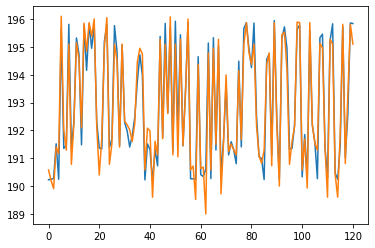

In [255]:
y_pred_test = model.predict(X_test)

plt.plot(output_scaler.inverse_transform(y_pred_test)[:,1])
plt.plot(output_scaler.inverse_transform(y_test)[:,1])
# plt.plot(y_pred_test[:,0])
# plt.plot(y_test.iloc[:,0].values)